# Setup

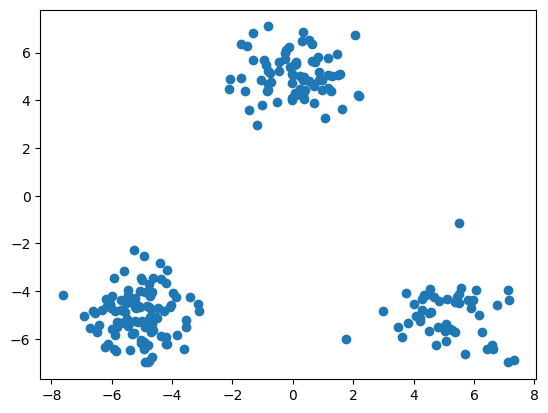

In [58]:
import numpy as np
import matplotlib as mpl
import pylab as plt
from scipy.stats import multivariate_normal

def get_data():
    np.random.seed(42)
    # training data
    x1 = np.random.normal(size=(100, 2))
    x1 += np.array([-5, -5])
    x2 = np.random.normal(size=(50, 2))
    x2 += np.array([5, -5])
    x3 = np.random.normal(size=(75, 2))
    x3 += np.array([0, 5])
    X = np.vstack((x1, x2, x3))
    return X

X = get_data()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# **Gaussian Mixture Models**
In this notebook, we will look at density modeling with *Gaussian mixture models* (GMMs), which describe the density of a data sample $\boldsymbol{x} \in \mathbb{R}^D$ as
$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\, \text{ with } \boldsymbol{\mu}_k \in \mathbb{R}^D\,,\, \boldsymbol{\Sigma}_k \in \mathbb{R}^{D \times D}\,,\, \pi_k \geq 0\,,\, \sum_{k=1}^K\pi_k = 1.
$$

The goal of this notebook is to get a better understanding of GMMs and to write some code for training GMMs using the *expectation-maximization-algorithm* (EM-algorithm) . We provide a code skeleton and mark the bits and pieces that you need to implement yourself.


We define the responsibilities (which are updated in the E-step), given the model parameters $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$ as
$$
r_{nk} = \frac{\pi_k\mathcal N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)}.
$$          
Given the responsibilities we just defined, we can update the model parameters in the M-step as follows:
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N},
\end{align*}
where
\begin{align*}
N_k = \sum_{n=1}^N r_{nk}.
\end{align*}


> **Implement a GMM with the EM-algorithm**

In [59]:
class GMM:
    """A GMM which is fitted through the EM-algorithm.

    Args:
        K (int): Number of components to be specified.
        n_iterations (int): Number of iterations of performing the EM algorithm.
        random_state (int): Random state to ensure reproducibility.

    """
    def __init__(self, K=3, n_iterations=10, random_state=5):
        self.K = K
        self.n_iterations = n_iterations
        self.random_state = random_state
        # init parameters
        self._set_inital_parameters()

    def density(self, X):
        """Computes component-wise densities of given samples.

        Args:
            X (array-like):  Samples whose densities are to be computed with shape (N, D).

        Returns:
            ndarray:  Computed densities per sample and component with shape (N, K). 
        """
        # compute densities
        # TODO: warum im Notebook oben eine Summe über K, wenn Rückgabeformat (N,K)?
        return np.reshape(np.array([self.mixing_coeff[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k]) for k in range(self.K)]).T, newshape=(X.shape[0], self.K))

    def negative_log_likelihood(self, X):
        """Computes negative loglikelihood (NLL) for given samples.

        Args:
            X (array-like): Samples for which NLL is to be computed with shape (N, D).

        Returns:
            float: Computed negative log-likelihood.
        """
        # compute NLL
        return -np.sum(np.log(np.sum([self.mixing_coeff[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k]) for k in range(self.K)], axis=0)))

    def fit(self, X, y=None):
        """Fits the GMM by performing the EM-algorithm.

        Args:
            X (array-like): Training samples with shape (N, D).

        Returns:
            self: The fitted GMM.
        """

        for _ in range(self.n_iterations):
            # E-step
            responsibilities = self._expectation(X)
            # M-step
            self._maximization(X, responsibilities)

    def predict(self, X):
        """Predicts components with highest responsibility per sample.

        Args:
            X (array-like): Samples whose most likely components are to be predicted with shape (N, D).


        Returns:
            ndarray:  Most likely components from which the samples were generated with shape (N).
        """
        # responsibilities
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)

    def predict_proba(self, X):
        """Predicts responsibilities of given samples.

        Args:
            X (array-like): Samples (N, D) whose responsibilities are to be computed.

        Returns:
            array-like: Computed responsibilities with shape (N, K).

        """
        return self._expectation(X)

    def _set_inital_parameters(self):
        """ Initializes the parameters of the GMM randomly. """
        # Defines random state for reproducibility.
        num_dim = 2
        if X.shape[1] > num_dim:
            num_dim = X.shape[1]
        random_state = np.random.RandomState(self.random_state)

        self.mu = random_state.randn(self.K, num_dim) 
        self.sigma = [np.identity(num_dim) for _ in range(self.K)] 
        self.mixing_coeff = np.ones(self.K) / self.K

    def _expectation(self, X):
        """Implements E-step by computing responsibilities.

        Args:
            X (array-like): Samples whose responsibilities are to be computed with shape (N, D).


        Returns:
            array-like: Computed responsibilities with shape (N, K).

        """
        responsibilities = np.array([])

        for sample in X:
    
            r_nk = np.array([self.mixing_coeff[k] * multivariate_normal.pdf(sample, self.mu[k], self.sigma[k]) for k in range(self.K)])
            r_nk /= np.sum(r_nk)
            
            
            responsibilities = np.vstack((responsibilities, r_nk)) if responsibilities.size else r_nk
      
        return responsibilities
        # Henrys approach (does not work yet)
        return np.reshape(self.density(X) / np.sum(self.density(X)), newshape=(X.shape[0], self.K))

    def _maximization(self, X, R):
        """Implements M-step by updating GMM parameters.

        Args:
            X (array-like): Samples whose responsibilities are to be computed with shape (N, D).
            R (array-like): Responsibilities of samples with (N, K).

        """
        responsibilities = R
     
        for k in range(self.K):
            Nk = np.sum(responsibilities[:, k])

            self.mu[k] = 1 / Nk * np.sum([responsibilities[i, k] * X[i] for i in range(X.shape[0])], axis=0)
            self.sigma[k] = 1 / Nk * np.sum([responsibilities[i, k] * np.outer(X[i] - self.mu[k], X[i] - self.mu[k]) for i in range(X.shape[0])], axis=0)
            self.mixing_coeff[k] = Nk / X.shape[0]
        

> **Plot the data and the density of the fitted GMM.** You can plot the density by using contour and the provided meshgrid.

In [60]:
gmm = GMM(K=3)
gmm.fit(X)

In [61]:
X_mesh, Y_mesh = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
pos = np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])
print(pos.shape)

densities = gmm.density(pos)

(10000, 2)


In [62]:
print(densities.shape)
print(densities)

(10000, 3)
[[4.06699105e-014 2.52224396e-048 8.12071556e-091]
 [1.48293169e-013 2.83079572e-047 7.22747370e-090]
 [5.11125563e-013 3.07838802e-046 6.17668763e-089]
 ...
 [2.99714872e-112 6.79574265e-056 1.22378695e-029]
 [5.42977676e-114 2.69648067e-056 1.66444567e-030]
 [9.29852757e-116 1.03669520e-056 2.17375366e-031]]


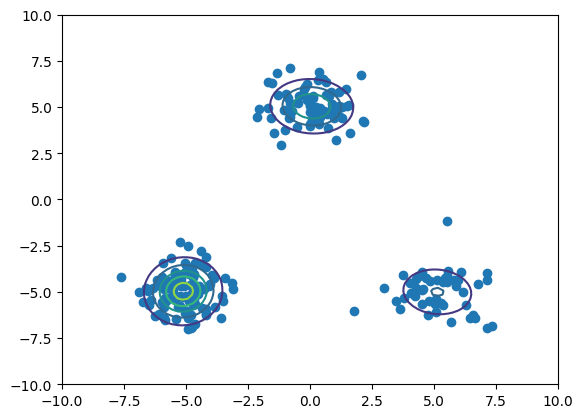

In [63]:
plt.contour(X_mesh, Y_mesh, gmm.density(pos).sum(axis=1).reshape(100, 100))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

#### **Questions:**

1. Can the NLL increase while performing the EM-Algorithm?
####################
 Your Text Here   
####################   
   
2. Is the EM-algorithm for the GMM guaranteed to converge?

####################
 Your Text Here   
####################   
   
3. How can we use the NLL as criterion for stopping the training of the GMM?

####################
 Your Text Here   
####################    